# MCMC: Understanding and usage



In [72]:
import numpy as np
import matplotlib.pyplot as plt

import corner

%matplotlib inline

## MCMC with a simple Metropolis 
- based on:  
https://github.com/AstroHackWeek/AstroHackWeek2016/blob/master/day4-sampling/Worksheet.ipynb

- the talk related to the Worksheet notebook above (starting from 1:50:40):
https://www.youtube.com/watch?v=3Xk2Rv5_Z0A&list=PLKW2Azk23ZtQSHmwOpObPEr58Pe1rpIdB&index=3


### Simple Metropolis implementation

Next, implement the basic MCMC algorithm described here in words:

1. Initialize the parameters as $\theta(t=0)$.
2. Propose an update $q = \theta(t) + \sigma\,\delta$ where $\sigma$ is a tuning parameter and $\delta$ is drawn from a zero mean, unit variance Gaussian. Alternatively, you can try changing only one dimension.
3. Compute the acceptance probability $r = \mbox{min}\left(1,\,\frac{p(q)}{p(\theta(t))}\right)$.
4. Draw $u$ from a uniform distribution between 0 and 1. If $u < r$, accept the proposal and set $\theta(t+1) = q$ to the chain. Otherwise, reject the proposal and set $\theta(t+1) = \theta(t)$. Append $\theta(t+1)$ to the chain.
5. Go to step 2 and repeat.

A few notes:

- Throughout this function, it might be useful to track the acceptance fraction. Keep track of how many proposals you accept.
- Don't compute or use $p(\theta)$ directly – you should only ever use the logarithm of this function.
- Your implementation should support _vector_ parameters. For this problem, we'll be working in 2-D but don't special case to that because it might be useful to be able to sample more parameters later :-)

In [73]:
def mh(log_p_func, theta0, niter, args, sigma=0.1):
    """A Simple Metropolis Sampler

    Parameters
    ----------
    log_p_func : function
        log of the posterior
    theta0: tuple
        starting point values to be sampled
    niter: int
        number of iterations to run
    args: tuple
        the data in the form of (x, y, yerr)
    sigma: float
        tuning parameter for the size of each step.
        it scales the width of the Gaussian drawn for the step size.

    Returns
    -------
    chain : ndarray
        an array in the shape (niter, len(theta0)),
        representing the accepted sample parameters
    """
    ndim = len(theta0)
    theta = np.array(theta0)
    chain = np.empty((niter, ndim))
    lp = log_p_func(theta0, *args)           # step 1 : initialization
    acc = 0
    for i in range(niter):
        q = np.array(theta)
        ind = np.random.randint(ndim)        # step 2: choose 1 parameter to change
        q[ind] += sigma * np.random.randn()  # step 2: then propose an update (scaled by sigma)

        u = np.log(np.random.rand())         # step 4 and 5: draw u and compare it with acceptance probability
        lq = log_p_func(q, *args)            #
        if u < lq - lp:                      #   - lq - lp is equivalent to acceptance probability
            theta = q                        #   - accept the proposal
            lp = lq
            acc += 1
        else:
            pass                             #    - reject the proposal, use the current value in the next iteration

        chain[i] = theta

    print("Acceptance fraction: {0:.3f}".format(acc / niter))

    return chain

### Convergence

Implement a function to compute the autocorrelation function. This should take in a one-dimensional chain and return a different autocorrelation function for each parameter. You probably shouldn't compute this using a direct sum – it will be too slow! – [try using a fast Fourier transform](https://en.wikipedia.org/wiki/Autocorrelation#Efficient_computation).

In [74]:
def acorfn(x):
    n = len(x)
    f = np.fft.rfft(x - np.mean(x), n=2*n)
    acf = np.fft.irfft(f * np.conjugate(f))[:n].real
    return acf / acf[0]

Computing autocorrelation time:
Read the suggested heuristic method for computing autocorelation times from pages 15-16 of [this note](http://www.stat.unc.edu/faculty/cji/Sokal.pdf) and implement 

In [75]:
def autocorr_time_simple(acf, window):
    return 1 + 2 * np.sum(acf[1:window])

def autocorr_time_iterative(acf, c=10, low=10):
    high = int(len(acf) / c)
    for M in np.arange(low, high).astype(int):
        tau = autocorr_time_simple(acf, M)
        if tau > 1.0 and M > c * tau:
            return tau
    raise RuntimeError("chain too short to estimate tau reliably")

# print(autocorr_time_iterative(acorfn(chain[:, 0])), autocorr_time_iterative(acorfn(chain[:, 1])))

### Sample linear data

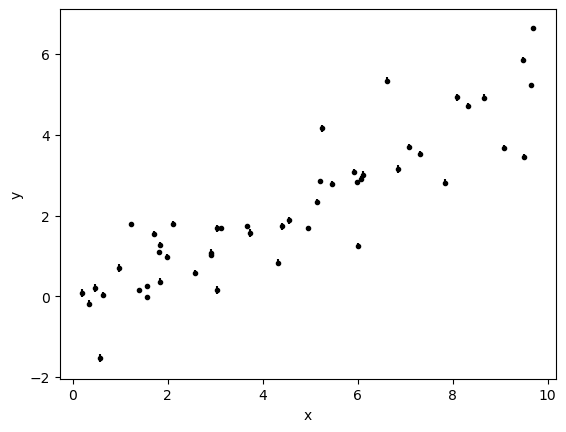

In [76]:
# local copy of https://github.com/AstroHackWeek/AstroHackWeek2016/blob/master/day4-sampling/data.txt
x, y, yerr = np.loadtxt("tmp/mcmc_understanding_sample_data.txt", unpack=True)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y");


### Model

The model that we'll use in this case is a linear model with a "jitter" term. In this model, the likelihood is:

$$
\ln p (y\,|\,m,\,b,\,s) = -\frac{1}{2} \sum_{n=1}^N\left[ \left(\frac{y_n-m\,x_n-b}{\sigma^2 + e^{s}}\right)^2 + \ln(2\,\pi\,(\sigma^2 + e^{s}))\right]
$$

and the prior is:

$$
\ln p(m,\,b,\,s) \propto -\frac{3}{2}\ln(1+b^2)
$$

(see [this blog post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) for more details about this choice of prior).

Implement this model in code:

In [77]:
def log_prior(theta):
    m, b, s = theta
    return -1.5 * np.log(1 + b**2)

def log_likelihood(theta, x, y, yerr):
    m, b, s = theta
    mod = m * x + b
    var = np.sqrt(yerr**2 + np.exp(s))
    return -0.5 * np.sum((y-mod)**2/var + np.log(var))

def log_posterior(theta, x, y, yerr):
    return log_prior(theta) + log_likelihood(theta, x, y, yerr)


### Run MCMC with `mh`

In [78]:
line_chain = mh(
    log_posterior,
    np.random.randn(3),  # has random starting point
    200000,  # num. iterations
    args=(x, y, yerr),
)

Acceptance fraction: 0.640


#### Trace plot / chain plot

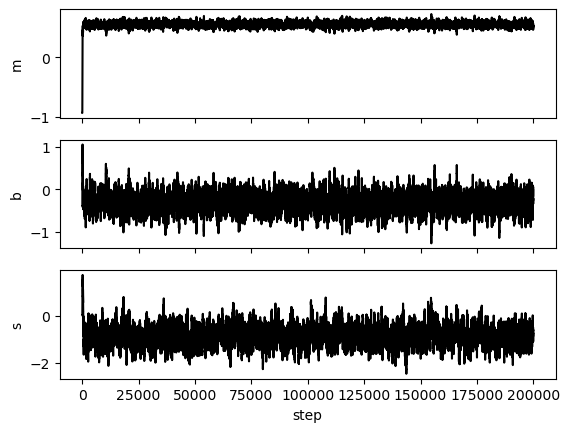

In [79]:
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(line_chain[:, 0], "k")
axes[0].set_ylabel("m")
axes[1].plot(line_chain[:, 1], "k")
axes[1].set_ylabel("b")
axes[2].plot(line_chain[:, 2], "k")
axes[2].set_ylabel("s")
axes[2].set_xlabel("step");

#### Convergence: Autocorrelation

In [80]:
line_chain.shape

(200000, 3)

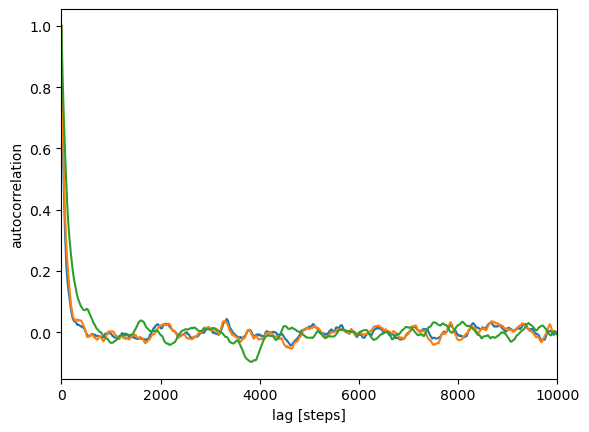

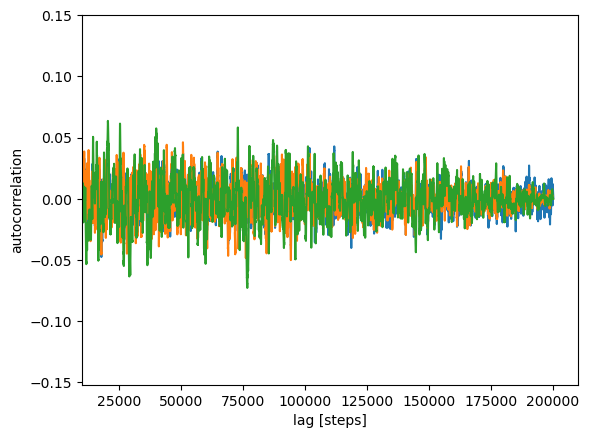

In [81]:
# settle down after about 2000 steps
plt.plot(acorfn(line_chain[:, 0]))
plt.plot(acorfn(line_chain[:, 1]))
plt.plot(acorfn(line_chain[:, 2]))
plt.xlim(0, 10000)

plt.xlabel("lag [steps]")
plt.ylabel("autocorrelation");
plt.show();

plt.plot(acorfn(line_chain[:, 0]))
plt.plot(acorfn(line_chain[:, 1]))
plt.plot(acorfn(line_chain[:, 2]))
plt.xlim(10000, None)
plt.ylim(None, 0.15)

plt.xlabel("lag [steps]")
plt.ylabel("autocorrelation");
plt.show();

Compute the autocorrelation times:

- suggests it needs about no more than 400 steps to "forget" where it started
- not unreasonable to throw away a few times this number as "burn-in".

In [82]:
print(autocorr_time_iterative(acorfn(line_chain[:, 0])),
      autocorr_time_iterative(acorfn(line_chain[:, 1])),
      autocorr_time_iterative(acorfn(line_chain[:, 2])))

125.05373157639858 140.6557967419224 281.6424029454561


#### Discard early chains and create Posterior Statistical Summary

In [83]:
# by eyeballing trace plots and autocorrelation plots
num_discards = 20000

line_chain_chosen = line_chain[num_discards:]

In [84]:
def create_posterior_summary(chain_dict):
    stats_dict = {}
    for param_name, chain in chain_dict.items():
        stats_dict[param_name] = dict(
            mean=np.nanmean(chain),
            std=np.nanstd(chain),
            num_iter=len(chain),
        )
    return stats_dict


line_chain_stats = create_posterior_summary(dict(
    m=line_chain_chosen[:, 0],
    b=line_chain_chosen[:, 1],
    s=line_chain_chosen[:, 2],
))

line_chain_stats

{'m': {'mean': 0.5530320952230581,
  'std': 0.0384140421411732,
  'num_iter': 180000},
 'b': {'mean': -0.3089991909090895,
  'std': 0.20126071847035207,
  'num_iter': 180000},
 's': {'mean': -0.8559265286148011,
  'std': 0.42450930820024757,
  'num_iter': 180000}}

#### The [corner plot](http://corner.readthedocs.io/)

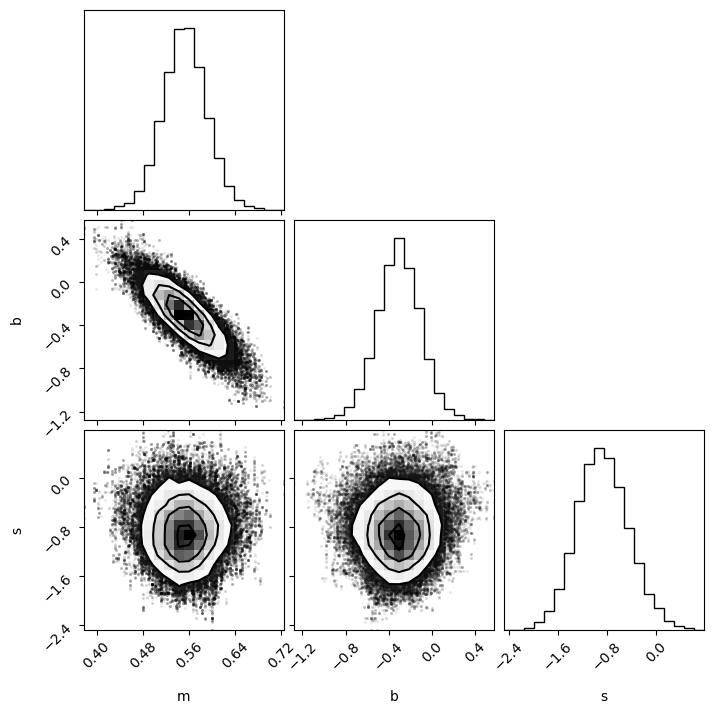

In [85]:
corner.corner(line_chain_chosen, labels=["m", "b", "s"]);

#### Model posterior prediction in the data space

Finally, plot the posterior prediction of the model in the data space. The best way to do this is to overplot the predicted line for several samples from the posterior on the data. Here is what it might look like:

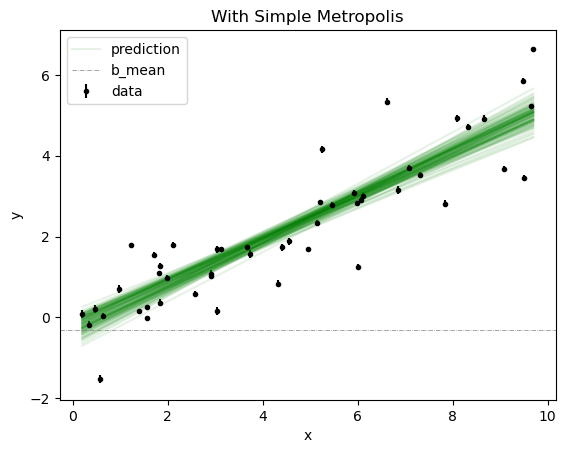

In [86]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="data")

for i, idx in enumerate(np.random.randint(len(line_chain_chosen), size=100)):
    m, b, _ = line_chain_chosen[idx]
    label = "prediction" if i == 0 else None
    plt.plot(x, m*x+b, "g", alpha=0.1, label=label)

plt.xlabel("x")
plt.ylabel("y");

plt.axhline(line_chain_stats["b"]["mean"], c="gray", lw=0.5, linestyle="-.", label="b_mean");
plt.title("With Simple Metropolis")
plt.legend();

## Run MCMC with `emcee`

- Do MCMC on the same data / model with `emcee`
- see also: https://emcee.readthedocs.io/en/stable/tutorials/line/

Recall how we did MCMC with the simple `mh`:

```python
line_chain = mh(
    log_posterior,
    np.random.randn(3),  # has random starting point
    200000,  # num. iterations
    args=(x, y, yerr),
)
```

#### Optional: Maximum likelihood estimate

- Estimate model parameters by estimating the maximum likelihood numerically with `scipy.optimize()`
- they could provide reasonable values for the model parameters
- they can also be used to choose good start points for the subsequent MCMC 

Maximum likelihood estimates:
m = 0.559
b = -0.344
s = -0.965


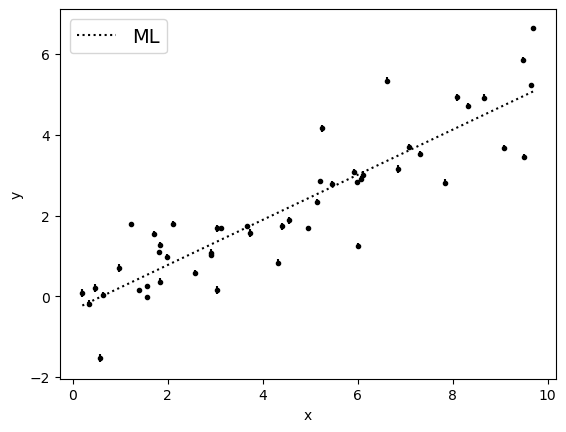

In [87]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([  # initial estimate by eyeballing the data
    0.5,   # m, the slope
    -0.1,  # b, the intercept
    0,     # s, the jitter
]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, s_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("s = {0:.3f}".format(s_ml))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(np.min(x), np.max(x), 500)  # for the purpose plotting here
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
# plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

### Run `emcee`

In [88]:
import emcee

# an ensemble of 32 walkers
nwalkers = 32
pos = 0 + np.random.randn(nwalkers, 3)  # still random starting point
# # alternative: to start at somewhere around  maximum likelihood result
# pos = soln.x + 1e-4 * np.random.randn(nwalkers, 3)

ndim = pos.shape[1]

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(x, y, yerr)
)
sampler.run_mcmc(
    pos,  # starting position
    50000, # num. iterations, we use fewer, assuming it'd converge faster
    progress=True
);

100%|██████████| 50000/50000 [00:56<00:00, 877.46it/s]


ensemble chains shape: (50000, 32, 3)


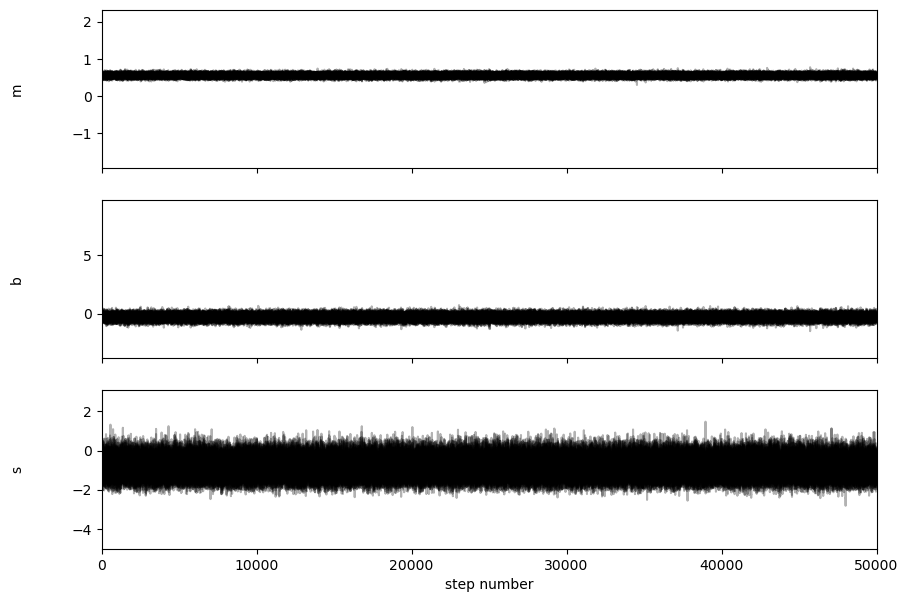

In [89]:
# Plot the chains,
# `samples` is analogous to `line_chains` in `mh`
#  the main difference it's an ensemble so it's an 3d array of
#  (num. iterations, nwalkers, num. params)

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print("ensemble chains shape:", samples.shape)
labels = ["m", "b", "s"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

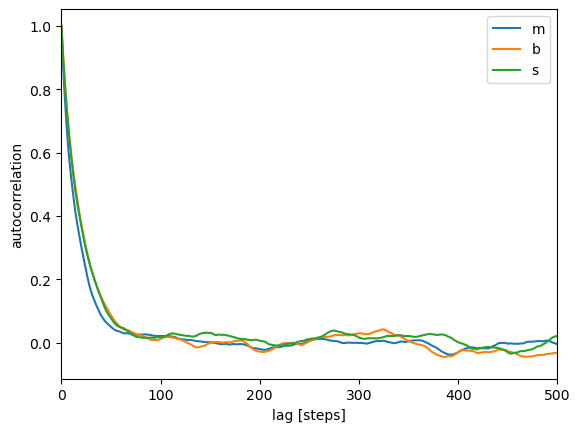

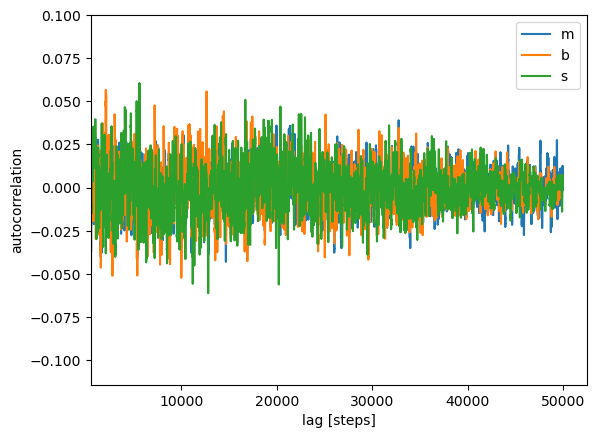

In [90]:
# show correlation time

def get_mean_samples(samples):
    nruns, nwalker, nparams = samples.shape
    return np.array([
        [ np.mean(samples[i, :, j]) for j in range(nparams) ]
        for i in range(nruns)
    ])


def plot_autocorrelation(samples, labels):
    mean_samples = get_mean_samples(samples)  # the ensemble samples

    ax = plt.figure().gca()
    for i, label in enumerate(labels):
        ax.plot(acorfn(mean_samples[:, i]), label=label)
    ax.set_xlabel("lag [steps]")
    ax.set_ylabel("autocorrelation");
    ax.legend();

    return ax


ax = plot_autocorrelation(sampler.get_chain(), labels=["m", "b", "s"]);
ax.set_xlim(0, 500);


ax = plot_autocorrelation(sampler.get_chain(), labels=["m", "b", "s"]);
ax.set_xlim(500, None);
ax.set_ylim(None, 0.1);


In [95]:
tau = sampler.get_autocorr_time()
print(tau)
print(max(tau))

[38.93610465 40.42144115 40.30163087]
40.421441145682856


In [ ]:
# `flat_samples_chosen` is analogous to `line_chains_chosen`
# - discard is few times over tau
# - thin is about half the autocorrelation time
flat_samples_chosen = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples_chosen.shape)

(104512, 3)


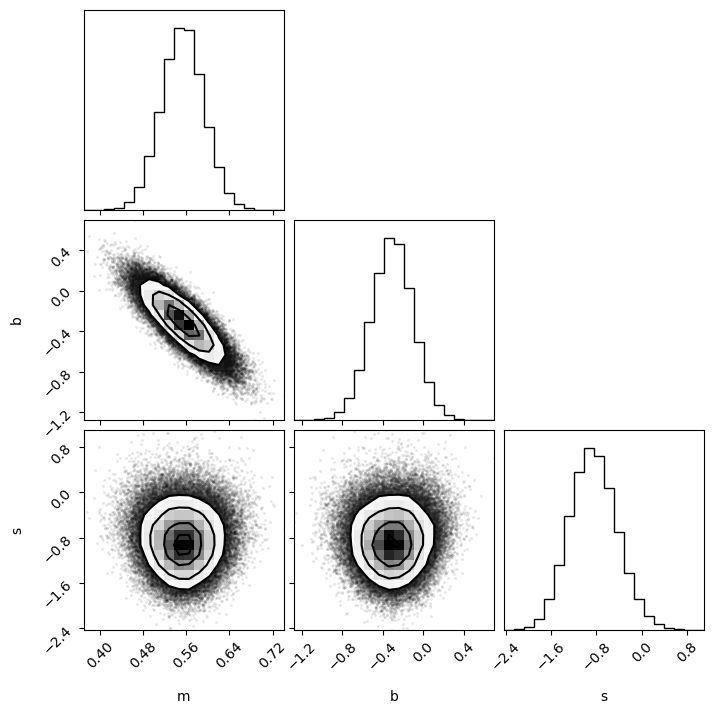

In [ ]:
import corner

fig = corner.corner(
    flat_samples_chosen, labels=labels,
    # truths=[m_true, b_true, np.log(f_true)]
);

In [40]:
flat_samples_stats = create_posterior_summary(dict(
    m=flat_samples_chosen[:, 0],
    b=flat_samples_chosen[:, 1],
    s=flat_samples_chosen[:, 2],
))
flat_samples_stats

{'m': {'mean': 0.5530688182971838,
  'std': 0.039262440240192986,
  'num_iter': 104512},
 'b': {'mean': -0.30973080014129084,
  'std': 0.20506271770499274,
  'num_iter': 104512},
 's': {'mean': -0.8469426685778292,
  'std': 0.41803598443753953,
  'num_iter': 104512}}

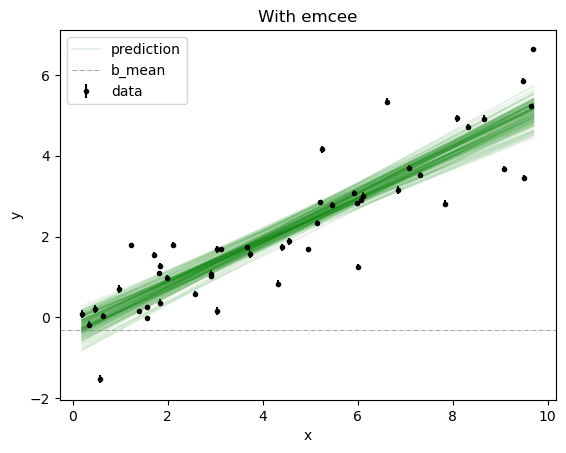

In [42]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="data")

for i, idx in enumerate(np.random.randint(len(flat_samples_chosen), size=100)):
    m, b, _ = flat_samples_chosen[idx]
    label = "prediction" if i == 0 else None
    plt.plot(x, m*x+b, "g", alpha=0.1, label=label)

plt.xlabel("x")
plt.ylabel("y");

plt.axhline(flat_samples_stats["b"]["mean"], c="gray", lw=0.5, linestyle="-.", label="b_mean");
plt.title("With emcee")
plt.legend();

## The effects of `discard` and `thin` in `get_chain()`

In [96]:
print("Simple flat: \t\t", sampler.get_chain(flat=True).shape)
print("")

# discard=100 => discard 100 steps, with 32 walkers => 32*100 = 3200 samples discarded in flattened samples
for discard, thin in [(100, 1), (1000, 1)]:
    print(f"Discard={discard} ; thin={thin}: \t", sampler.get_chain(discard=discard, thin=thin, flat=True).shape)

print("")

# thin=10 => take a sample of every 10 steps in the (flattened?) chain => 10% of the samples would be taken
for discard, thin in [(100, 1), (100, 10), (100, 100)]:
    print(f"Discard={discard} ; thin={thin}: \t", sampler.get_chain(discard=discard, thin=thin, flat=True).shape)


Simple flat: 		 (1600000, 3)

Discard=100 ; thin=1: 	 (1596800, 3)
Discard=1000 ; thin=1: 	 (1568000, 3)

Discard=100 ; thin=1: 	 (1596800, 3)
Discard=100 ; thin=10: 	 (159680, 3)
Discard=100 ; thin=100: 	 (15968, 3)
